<a href="https://colab.research.google.com/github/HLapendery/FootballAnalysis/blob/master/2018WorldCup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data collection from StatsBomb github

Importing needed libraries

In [0]:
import pandas as pd
from tqdm import tqdm
import requests as rq

Indexing available competitions

In [0]:
comps_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/competitions.json"

df_comps = pd.read_json(comps_url)

Find infos for the 2018 world cup

In [4]:
df_comps[df_comps['competition_name'] == 'FIFA World Cup']


,competition_id,season_id,country_name,competition_name,competition_gender,season_name,match_updated,match_available
2,43,3,International,FIFA World Cup,male,2018,2019-12-16T23:09:16.168756,2019-12-16T23:09:16.168756


Parse data (Code by Devin Pleuler in his [handbook](https://github.com/devinpleuler/analytics-handbook))

In [0]:
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

def parse_data(competition_id, season_id):
    matches = rq.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [m['match_id'] for m in matches]

    all_events = []
    for match_id in tqdm(match_ids):

        events = rq.get(url=match_url.format(match_id)).json()

        shots = [x for x in events if x['type']['name'] == "Shot"]
        for s in shots:
            attributes = {
                "match_id": match_id,
                "team": s["possession_team"]["name"],
                "player": s['player']['name'],
                "x": s['location'][0],
                "y": s['location'][1],
                "outcome": s['shot']['outcome']['name'],
            }
            all_events.append(attributes)
            
    return pd.DataFrame(all_events)

In [6]:
df = parse_data(43,3)

100%|██████████| 64/64 [00:33<00:00,  1.94it/s]


In [7]:
df_save = df.copy()
df = df_save.copy()
df.shape
df.head()
df_save.head()

,match_id,team,player,x,y,outcome
0,7562,Australia,Mile Jedinak,97.0,53.0,Off T
1,7562,Australia,Tom Rogić,95.0,46.0,Blocked
2,7562,Peru,André Martín Carrillo Díaz,104.0,53.0,Goal
3,7562,Australia,Mathew Leckie,112.0,42.0,Wayward
4,7562,Peru,José Paolo Guerrero González,109.0,37.0,Saved


# Plotting Shots

Re-locate coordinates of the shots from a 120x80 to a 105x68 pitch sized

In [0]:
df['x'] = list(map(lambda x: (x*105)/120,df['x']))
df['y'] = list(map(lambda x: (x*68)/80,df['y']))

In [9]:
!pip install matplotsoccer

  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-cp36-none-any.whl size=5984 sha256=d21f75ad1bd6692c458ca93efa75b95d53e06843d5dd79249c5d167c1b0c2f0f
  Stored in directory: /root/.cache/pip/wheels/69/af/8d/ee61635d6f863657abe8cd0c22622c408a4b980d5af1974f1f
Successfully built matplotsoccer


Plotting a soccer field and all the shots taken during the WC colored by teams.

In [0]:
import matplotlib.pyplot as plt
import matplotsoccer

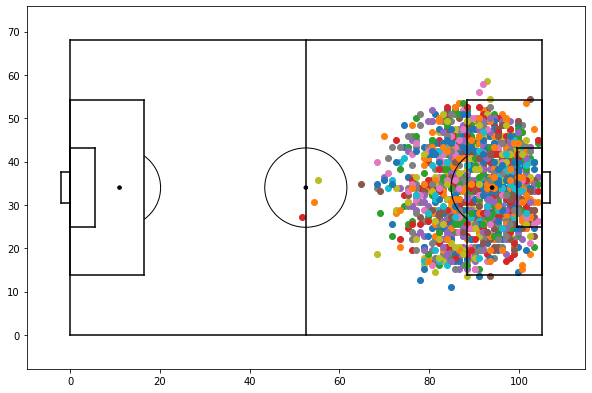

In [11]:
matplotsoccer.field(figsize=10, show=False)
for i,t in enumerate(df['team'].unique()):
  plt.scatter(df['x'][df['team'] == t],df['y'][df['team'] == t])
plt.axis("on")
plt.show()

In [13]:
!pip install scipy

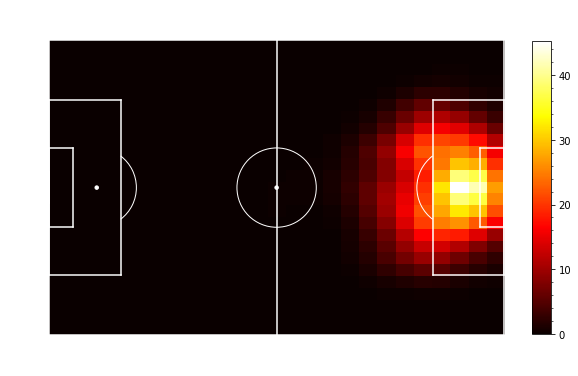

In [17]:
import scipy.ndimage

hm = matplotsoccer.count(df['x'],df['y'],n=25,m=25) # Construct a 25x25 heatmap from x,y-coordinates
hm = scipy.ndimage.gaussian_filter(hm,1) # blur the heatmap
matplotsoccer.heatmap(hm,cmap="hot",linecolor="white",cbar=True,figsize=10)

# Plotting Goals

Plotting a soccer field and all the shots taken during the WC colored by outcome.

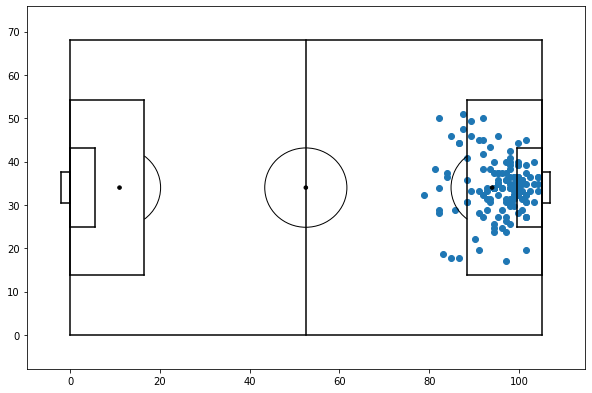

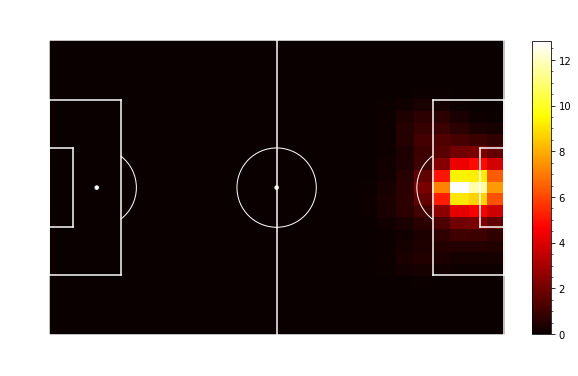

In [18]:
matplotsoccer.field(figsize=10, show=False)
x = df['x'][df['outcome'] == "Goal" ]
y = df['y'][df['outcome'] == "Goal"]
plt.scatter(x, y)
plt.axis("on")
plt.show()
hm = matplotsoccer.count(x, y,n=25,m=25) # Construct a 25x25 heatmap from x,y-coordinates
hm = scipy.ndimage.gaussian_filter(hm,1) # blur the heatmap
matplotsoccer.heatmap(hm,cmap="hot",linecolor="white",cbar=True,figsize=10)

# Goals Summary

## Treemap of the number of goals scored by nation

First we need to create a DataFrame with the correct data

In [0]:

Goals_count = df.loc[:,['team','match_id']][df['outcome'] == 'Goal'].groupby('team').count().reset_index()
Goals_count.columns = ['Teams','Goals']
Goals_count = Goals_count.sort_values(by=['Goals'],ascending =False)

In [24]:
!pip install squarify

Visualization of the most prolific Nations

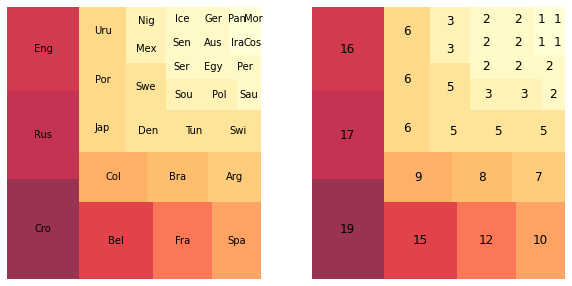

In [65]:
import squarify
import matplotlib
import numpy as np
teams = Goals_count['Teams']
goals = Goals_count['Goals']

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax1.axis('off')
ax2 = fig.add_subplot(122)
ax2.axis('off')
mini,maxi = goals.min(), goals.max()
cmap = matplotlib.cm.YlOrRd
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(g)) for g in goals]
teams = list(map(lambda t: t[:3],teams))
squarify.plot(sizes=goals, label=teams, alpha=.8, color=colors, ax=ax1, text_kwargs={'fontsize':10})
squarify.plot(sizes=goals, label=goals, alpha=.8, color=colors, ax=ax2, text_kwargs={'fontsize':12})
plt.show() 

# Goals by player

In [0]:
Goals_player = df.loc[:,['player','match_id']][df['outcome'] == 'Goal'].groupby('player').count().reset_index()
Goals_player.columns = ['Player','Goals']
Goals_player = Goals_player.sort_values(by=['Goals'],ascending =False)